<a href="https://colab.research.google.com/github/Chiamakac/IgboNER-Models/blob/main/Confusion%20matrix/confusion_matrix_of_mBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install the Transformers and Datasets libraries to run this notebook.**

In [ ]:
!pip install transformers
!pip install datasets

import transformers
from datasets import load_dataset

In [ ]:
#We use the load_dataset() method from the Datasets library to download our dataset.
raw_datasets = load_dataset('masakhaner', 'ibo')#replace with your dataset name

In [3]:
#We mount the gdrive where our model checkpoint is saved.
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#Describe the model path
# Replace this with your own model path
MODEL_PATH = "/content/gdrive/MyDrive/IBO_BETA/ LREC FINAL TRAINING/bert-base-multilingual-cased checkpoint-5600"

In [5]:
#Using the fine-tuned model
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "/content/gdrive/MyDrive/IBO_BETA/ LREC FINAL TRAINING/bert-base-multilingual-cased checkpoint-5600"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)

In [6]:
def get_actual_tags(word, tag):
  if ' ' in word:
    words = word.split()
    return [(words[0], f"B-{tag}")]+[(w,  f"I-{tag}") for w in words[1:]]
  else:
    return [(word, f"B-{tag}")]

In [7]:
#Have a look at the features attribute of our dataset
ner_feature = raw_datasets["train"].features["ner_tags"]
ner_feature

Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE'], names_file=None, id=None), length=-1, id=None)

In [8]:
#we can access the list of names by looking at the names attribute of that feature
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE']

In [9]:
#Preparing our actual and predicted tags
actual_tags, predicted_tags = [], []
for i in range(len(raw_datasets['test'])): 
  actual_tags.extend(raw_datasets['test'][i]['ner_tags']) # actual_tags += raw_datasets['test'][i]['ner_tags']
  sent = ' '.join(raw_datasets['test'][i]['tokens'])
  preds = [(i['word'].strip(),i['entity_group']) for i in token_classifier(sent)]
  results=[]
  for r in preds: results.extend(get_actual_tags(r[0], r[1]))
  results_dict = {w:t for w,t in results}  #not sure this is a good idea...
  predicted_tags.extend([label_names.index(results_dict[w]) if w in results_dict else label_names.index("O") for w in sent.split()])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


**We can create the confusion matrix using the confusion_matrix() method from sklearn.metrics package.** 

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
confusion_matrix(actual_tags,predicted_tags)

**Plotting a confusion matrix with matplotlib and seaborn**

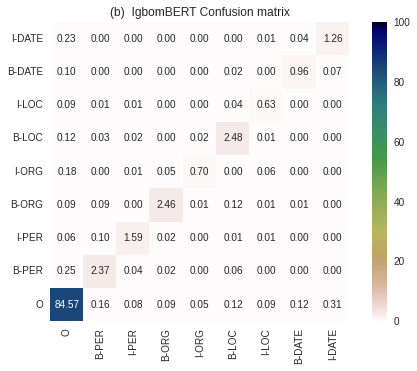

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

import seaborn as sns
import math

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib as mpl

mpl.style.use('seaborn')

conf_arr = np.array([[10694,    20,    10,    11,     6,    15,    11,    15,    39],
                     [   31,   300,     5,     2,     0,     7,     0,     0,     0],
                     [    8,    13,   201,     2,     0,     1,     1,     0,     0],
                     [   11,    11,     0,   311,     1,    15,     1,     1,     0],
                     [   23,     0,     1,     6,    88,     0,     8,     0,     0],
                     [   15,     4,     2,     0,     3,   313,     1,     0,     0],
                     [   12,     1,     1,     0,     0,     5,    80,     0,     0],
                     [   13,     0,     0,     0,     0,     2,     0,   121,     9],
                     [   29,     0,     0,     0,     0,     0,     1,     5,   159]])

sum = conf_arr.sum()

conf_arr = conf_arr * 100.0 / ( 1.0 * sum )

df_cm = pd.DataFrame(conf_arr, 
  index = [ 'O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE'],
  columns = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE'])
fig = plt.figure()
plt.clf()

ax = fig.add_subplot(111)
ax.set_aspect(1)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

res = sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f', cmap='gist_earth_r')

res.invert_yaxis()

plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5], [ 'O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE'],va='center')

plt.title('(b)  IgbomBERT Confusion matrix')

plt.savefig('confusion_matrix.png', dpi=100, bbox_inches='tight' )

plt.show()